<a href="https://colab.research.google.com/github/mohsina680/DS-Practice-Projects/blob/main/Clustering_Project_Mall_Customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster import hierarchy
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

# Helper: show and save plots inline-friendly
def show_plot():
    plt.tight_layout()
    plt.show()

def save_fig(fname):
    plt.tight_layout()
    plt.savefig(fname, dpi=150)

print('Libraries imported. Ready.')

Libraries imported. Ready.


In [ ]:
# 1. Load dataset (local first, then fallback)
from pathlib import Path
local = Path('Mall_Customers.csv')
if local.exists():
    df = pd.read_csv(local)
    print('Loaded Mall_Customers.csv from local folder.')
else:
    print('Mall_Customers.csv not found locally. Attempting fallback download (public gist)...')
    try:
        fallback = 'https://raw.githubusercontent.com/mohsina680/Web_Project/main/Travel%20Log/Mall_Customers.csv'
        df = pd.read_csv(fallback)
        print('Downloaded dataset from fallback URL. Saved local copy.')
        df.to_csv(local, index=False)
    except Exception as e:
        raise FileNotFoundError('Mall_Customers.csv not found locally and fallback download failed. Please upload the CSV next to this notebook.')

print('\nDataset shape:', df.shape)
print('\nColumns:', df.columns.tolist())

df.head()

Loaded Mall_Customers.csv from local folder.

Dataset shape: (200, 5)

Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing values per column:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Descriptive statistics:
                        count unique     top freq   mean        std   min  \
CustomerID              200.0    NaN     NaN  NaN  100.5  57.879185   1.0   
Genre                     200      2  Female  112    NaN        NaN   NaN   
Age                     200.0    NaN   

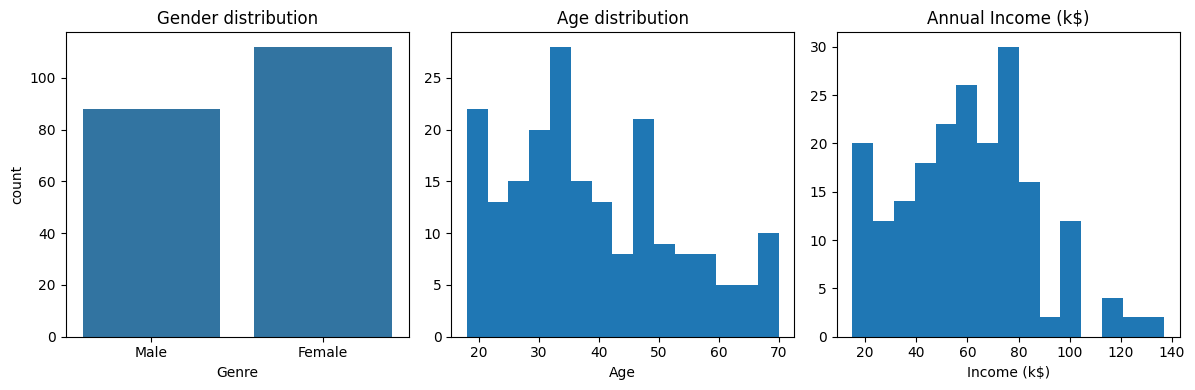

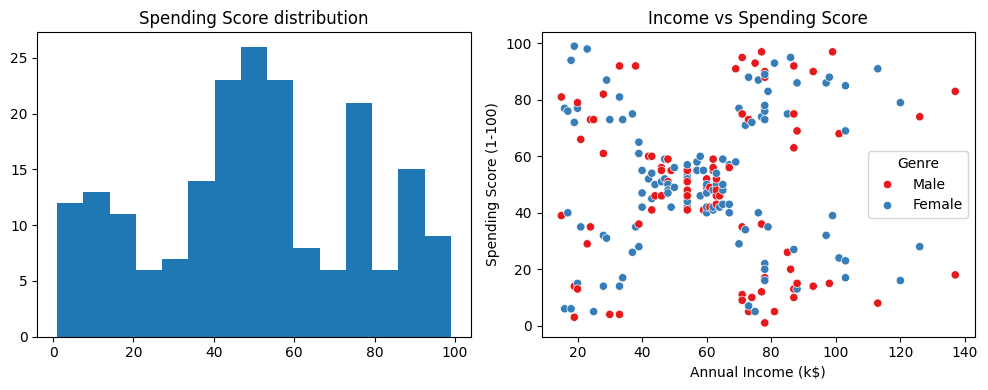

In [ ]:
# Basic EDA
print('Info:')
df.info()

print('\nMissing values per column:')
print(df.isnull().sum())

print('\nDescriptive statistics:')
print(df.describe(include='all').T)

# Standard plots
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.countplot(data=df, x='Genre')
plt.title('Gender distribution')

plt.subplot(1,3,2)
plt.hist(df['Age'], bins=15)
plt.title('Age distribution')
plt.xlabel('Age')

plt.subplot(1,3,3)
plt.hist(df['Annual Income (k$)'], bins=15)
plt.title('Annual Income (k$)')
plt.xlabel('Income (k$)')
show_plot()

# Spending score distribution and Income vs Spending
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['Spending Score (1-100)'], bins=15)
plt.title('Spending Score distribution')

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre', palette='Set1')
plt.title('Income vs Spending Score')
show_plot()

In [ ]:
# Select features for clustering (primary: Income & Spending Score)
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

# Check for NaNs
if X.isnull().any().any():
    print('Missing values found in features — filling with column mean')
    X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Feature matrix shape:', X_scaled.shape)
print('Feature names:', features)

Feature matrix shape: (200, 2)
Feature names: ['Annual Income (k$)', 'Spending Score (1-100)']


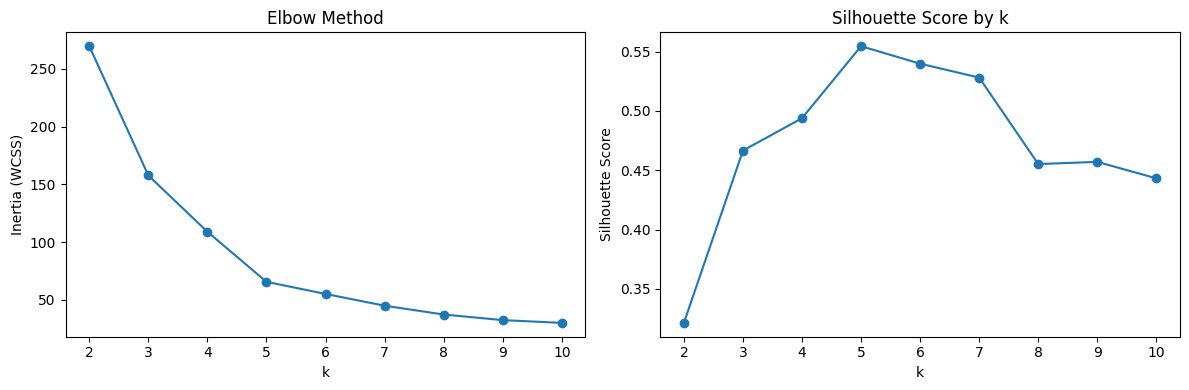

Recommended k by silhouette: 5


,k,inertia,silhouette
0,2,269.691012,0.321271
1,3,157.704008,0.466585
2,4,108.921317,0.493907
3,5,65.568408,0.554657
4,6,55.057348,0.539880
5,7,44.864756,0.528149
6,8,37.228188,0.455215
7,9,32.392268,0.457085
8,10,29.981898,0.443171


In [ ]:
# Evaluate k from 2 to 10
inertias = []
sil_scores = []
K_range = range(2,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(1,2,2)
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
show_plot()

best_k = list(K_range)[int(np.argmax(sil_scores))]
print(f'Recommended k by silhouette: {best_k}')

# Store results for later
elbow_data = pd.DataFrame({'k':list(K_range),'inertia':inertias,'silhouette':sil_scores})
elbow_data

Cluster sizes:
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


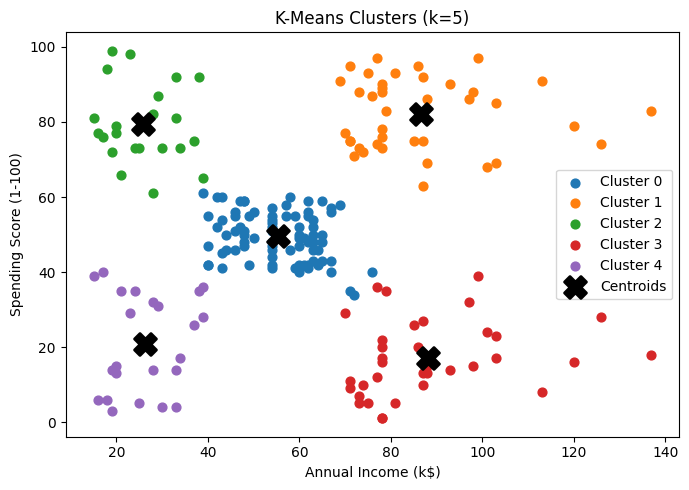

Age        Annual Income (k$)        Spending Score (1-100)  \
               count   mean              count   mean                  count   
KMeans_Cluster                                                                 
0                 81  42.72                 81  55.30                     81   
1                 39  32.69                 39  86.54                     39   
2                 22  25.27                 22  25.73                     22   
3                 35  41.11                 35  88.20                     35   
4                 23  45.22                 23  26.30                     23   

                       
                 mean  
KMeans_Cluster         
0               49.52  
1               82.13  
2               79.36  
3               17.11  
4               20.91

In [ ]:
# Fit K-Means with best_k
k_final = int(best_k)
km = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init=50)
labels_km = km.fit_predict(X_scaled)
df['KMeans_Cluster'] = labels_km
centroids_scaled = km.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

print('Cluster sizes:')
print(pd.Series(labels_km).value_counts().sort_index())

# Plot clusters in original feature space
plt.figure(figsize=(7,5))
palette = sns.color_palette('tab10', n_colors=k_final)
for i in range(k_final):
    pts = df[df['KMeans_Cluster']==i]
    plt.scatter(pts['Annual Income (k$)'], pts['Spending Score (1-100)'], s=40, label=f'Cluster {i}')
plt.scatter(centroids[:,0], centroids[:,1], marker='X', s=250, linewidths=2, color='k', label='Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title(f'K-Means Clusters (k={k_final})')
plt.legend()
show_plot()

# Profiling
profile_km = df.groupby('KMeans_Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].agg(['count','mean']).round(2)
profile_km

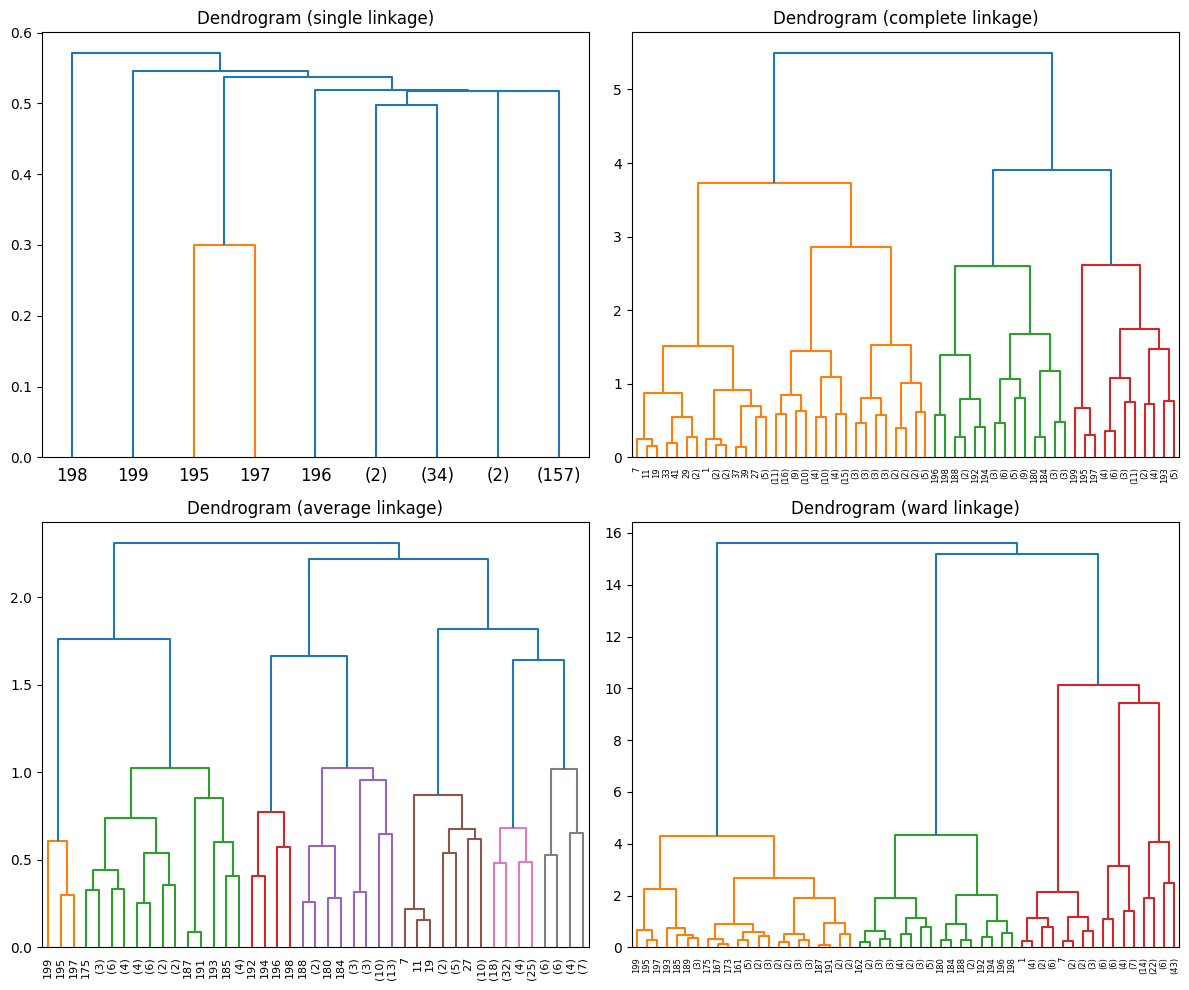

Hierarchical cluster sizes:
0    32
1    39
2    85
3    21
4    23
Name: count, dtype: int64


In [ ]:
linkages = ['single','complete','average','ward']
plt.figure(figsize=(12,10))
for i, link in enumerate(linkages,1):
    plt.subplot(2,2,i)
    Z = hierarchy.linkage(X_scaled, method=link)
    sch.dendrogram(Z, truncate_mode='level', p=5)
    plt.title(f'Dendrogram ({link} linkage)')
show_plot()

# Cut dendrogram to form clusters: choose same k_final for comparison
agg = AgglomerativeClustering(n_clusters=k_final, linkage='ward')
labels_h = agg.fit_predict(X_scaled)
df['Hierarchical_Cluster'] = labels_h
print('Hierarchical cluster sizes:')
print(pd.Series(labels_h).value_counts().sort_index())

In [ ]:
sil_km = silhouette_score(X_scaled, df['KMeans_Cluster'])
sil_h = silhouette_score(X_scaled, df['Hierarchical_Cluster'])
db_km = davies_bouldin_score(X_scaled, df['KMeans_Cluster'])
db_h = davies_bouldin_score(X_scaled, df['Hierarchical_Cluster'])

metrics = pd.DataFrame({
    'Algorithm':['K-Means','Hierarchical (Ward)'],
    'Silhouette':[round(sil_km,4), round(sil_h,4)],
    'Davies-Bouldin':[round(db_km,4), round(db_h,4)]
})
metrics

,Algorithm,Silhouette,Davies-Bouldin
0,K-Means,0.5547,0.5722
1,Hierarchical (Ward),0.5538,0.5779


Explained variance ratio (2 components): [0.505 0.495]


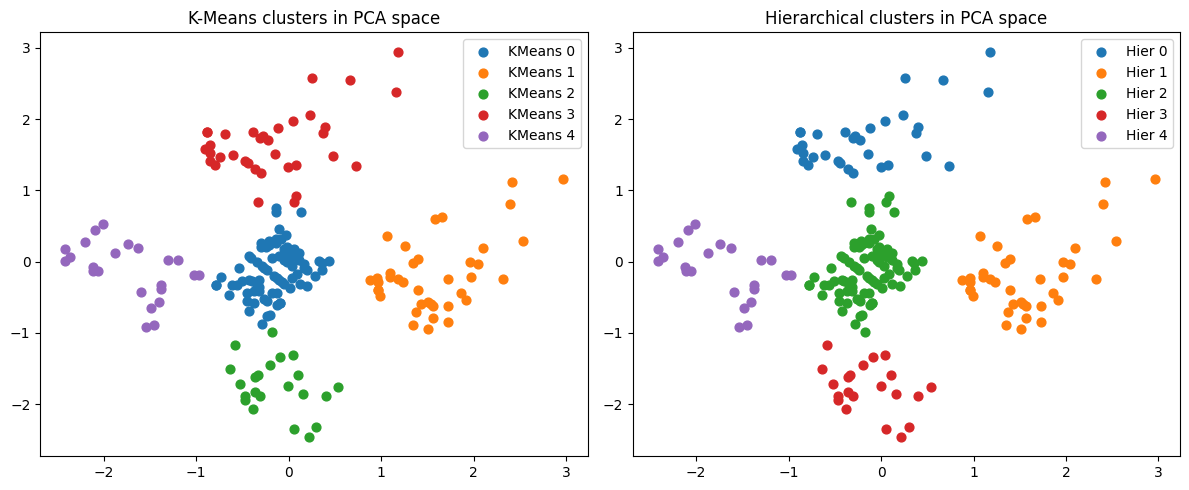

In [ ]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratio (2 components):', np.round(pca.explained_variance_ratio_,3))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for lbl in sorted(df['KMeans_Cluster'].unique()):
    pts = X_pca[df['KMeans_Cluster']==lbl]
    plt.scatter(pts[:,0], pts[:,1], s=40, label=f'KMeans {lbl}')
plt.title('K-Means clusters in PCA space')
plt.legend()

plt.subplot(1,2,2)
for lbl in sorted(df['Hierarchical_Cluster'].unique()):
    pts = X_pca[df['Hierarchical_Cluster']==lbl]
    plt.scatter(pts[:,0], pts[:,1], s=40, label=f'Hier {lbl}')
plt.title('Hierarchical clusters in PCA space')
plt.legend()
show_plot()

In [ ]:
# Create a profiling table for KMeans clusters
prof = df.groupby('KMeans_Cluster').agg(
    Count=('CustomerID','count'),
    Mean_Age=('Age','mean'),
    Mean_Income_k=('Annual Income (k$)','mean'),
    Mean_Spend=('Spending Score (1-100)','mean')
).round(2).reset_index().sort_values('KMeans_Cluster')

print(prof)
prof.to_csv('KMeans_cluster_profile.csv', index=False)
print('\nSaved KMeans_cluster_profile.csv')

# Also save labeled dataset
df.to_csv('Mall_Customers_with_clusters.csv', index=False)
print('Saved Mall_Customers_with_clusters.csv')

   KMeans_Cluster  Count  Mean_Age  Mean_Income_k  Mean_Spend
0               0     81     42.72          55.30       49.52
1               1     39     32.69          86.54       82.13
2               2     22     25.27          25.73       79.36
3               3     35     41.11          88.20       17.11
4               4     23     45.22          26.30       20.91

Saved KMeans_cluster_profile.csv
Saved Mall_Customers_with_clusters.csv


In [ ]:
print('Metrics comparison:')
print(metrics.to_string(index=False))

print('\nCluster profiling (KMeans):')
print(prof.to_string(index=False))

print('\nSuggested next steps:')
print('- Review cluster centroids and assign human-readable labels (High-Income High-Spenders, etc.).')
print('- Target marketing per cluster: loyalty for high-value, promotions for price-sensitive, retention for low engagement.')
print('- Re-run clustering periodically to capture drift (quarterly).')

print('\nFiles created: KMeans_cluster_profile.csv, Mall_Customers_with_clusters.csv')

Metrics comparison:
          Algorithm  Silhouette  Davies-Bouldin
            K-Means      0.5547          0.5722
Hierarchical (Ward)      0.5538          0.5779

Cluster profiling (KMeans):
 KMeans_Cluster  Count  Mean_Age  Mean_Income_k  Mean_Spend
              0     81     42.72          55.30       49.52
              1     39     32.69          86.54       82.13
              2     22     25.27          25.73       79.36
              3     35     41.11          88.20       17.11
              4     23     45.22          26.30       20.91

Suggested next steps:
- Review cluster centroids and assign human-readable labels (High-Income High-Spenders, etc.).
- Target marketing per cluster: loyalty for high-value, promotions for price-sensitive, retention for low engagement.
- Re-run clustering periodically to capture drift (quarterly).

Files created: KMeans_cluster_profile.csv, Mall_Customers_with_clusters.csv
